## Problem Statement: 
During exploratory data analysis, a baseline scores of Root Mean Square Error (RMSE) of 11.1 and R^2 of 0.56 was established by comparing true time series data with the mean number of visitors per certain weekday fper each restaurant individually. The aim of the further analysis is to obtain a better RMSE score by modeling the predictions with various techniques.

In [12]:
# import sys
# sys.path

In [13]:
#!pip install pmdarima

In [14]:
#!pip install keras

In [15]:
#!pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator

# Configure Plotly to be rendered inline in the notebook.
#plotly.offline.init_notebook_mode()

/anaconda3/envs/dsi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [2]:
air_res = pd.read_csv('../data/air_reserve.csv')
air_info = pd.read_csv('../data/air_store_info.csv')
air_visit = pd.read_csv('../data/air_visit_data.csv')
#hpg_res = pd.read_csv('../data/hpg_reserve.csv')
#hpg_info = pd.read_csv('../data/hpg_store_info.csv')

store_id = pd.read_csv('../data/store_id_relation.csv')
date_info=pd.read_csv('../data/date_info.csv')



In [175]:
# air_dist=pd.read_csv('./rrv-weather-data/air_station_distances.csv')
# air_info_station = pd.read_csv('./rrv-weather-data/air_store_info_with_nearest_active_station.csv')
# hpg_dist=pd.read_csv('./rrv-weather-data/hpg_station_distances.csv')
# hpg_info_station=pd.read_csv('./rrv-weather-data/hpg_store_info_with_nearest_active_station.csv')
# feature_man=pd.read_csv('./rrv-weather-data/feature_manifest.csv')
# stations=pd.read_csv('./rrv-weather-data/weather_stations.csv')
# ac_stations=pd.read_csv('./rrv-weather-data/nearby_active_stations.csv')


In [176]:
air_res.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [177]:
#air_info_station.head()

In [178]:
# df['Date']=pd.to_datetime(df['Date'])
# df.dtypes
air_res['rDate']=pd.to_datetime(air_res['reserve_datetime'])
air_visit.set_index('visit_date', inplace=True)
air_visit.index = pd.to_datetime(air_visit.index )
air_visit.index

DatetimeIndex(['2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21',
               '2016-01-22', '2016-01-23',
               ...
               '2017-04-11', '2017-04-12', '2017-04-13', '2017-04-14',
               '2017-04-15', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', name='visit_date', length=252108, freq=None)

In [179]:
air_visit.shape

(252108, 2)

##  Modeling of First Store data with Auto ARIMA

First, ARIMA time series analysis was performed. The time series data for one of the stores was used as an example. The autocorrelation and partial autocorrelation of time points in the data was examined and strong weekly correlation between data point was detected.  Data was checked for stationarity and appropriate degree of differencing of the data was determined using Dickey-Fuller test to make it stationary and appropriate for ARIMA analysis.  Auto_arima model from ‘pmdarima’ python package was used to further optimize and find optimal parameters of p (autoregressive term) and q (moving average order) for daily as well as Seasonal parts of auto_arima. Visual inspection of the result revealed poor fit of weekly/daily trend, however with a good overall yearly trend of the time series. RMSE metric was found to be higher than the baseline score even with optimal parameters.

In [10]:
rest_id= air_visit['air_store_id'].unique()

In [181]:
rest_id= air_visit['air_store_id'].unique()
store1 = air_visit[air_visit['air_store_id']==rest_id[0]]
store1.head()
store1.drop(columns='air_store_id', inplace=True)
store1.head()

/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,visitors
visit_date,
2016-01-13,25
2016-01-14,32
2016-01-15,29
2016-01-16,22
2016-01-18,6


In [182]:
#store11=store1

In [183]:
# store11['index'] = pd.date_range(start='1/13/2016', end='4/22/2017', # start date 
# #                                #periods=len(air_visit.index), # we want one period per entry
#                                 freq='D')

In [184]:
store1.index

DatetimeIndex(['2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21',
               '2016-01-22', '2016-01-23',
               ...
               '2017-04-13', '2017-04-14', '2017-04-15', '2017-04-16',
               '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', name='visit_date', length=391, freq=None)

In [185]:
# store1.index = pd.date_range('1/13/2016','2017-04-22', # start date 
#                                periods=len(store1.index), # we want one period per entry
#                               ) # freq='W'

In [186]:
# pd.to_datetime(store1.index )

Text(0.5, 1.0, 'Mean Visitors Over Time Store 1 ')

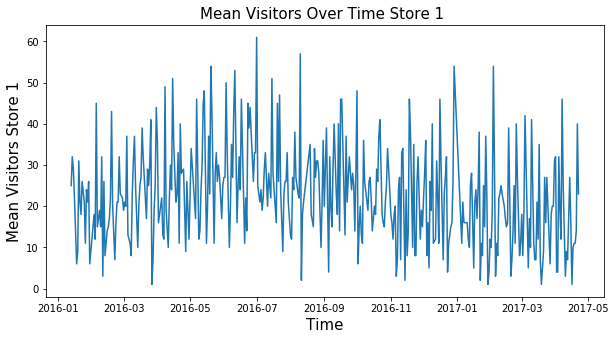

In [187]:
plt.figure(figsize=(10,5))
plt.plot(store1)
plt.ylabel('Mean Visitors Store 1', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Mean Visitors Over Time Store 1 ', fontsize=15)

In [188]:
# !pip install .filters._utils
# from .filters._utils import _maybe_get_pandas_wrapper_freq

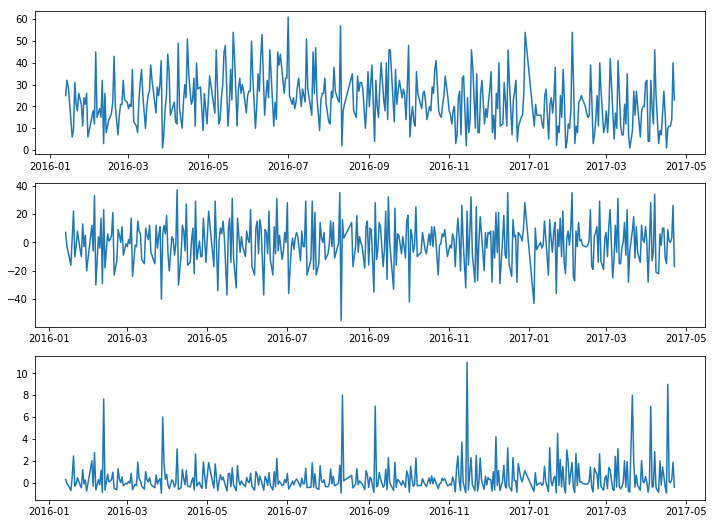

In [189]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 9))
ax[0].plot(store1)
ax[1].plot(store1.diff())
ax[2].plot(store1.pct_change())
# plotly.offline.init_notebook_mode()

In [190]:
store1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 391 entries, 2016-01-13 to 2017-04-22
Data columns (total 1 columns):
visitors    391 non-null int64
dtypes: int64(1)
memory usage: 6.1 KB


### Define Train and Test data for Store 1: 
Select about 70% of time points as Train Set and the lat 30% of time points as Test Set.

In [191]:
train, test = store1[:294], store1[294:]

In [192]:
train.index.isnull().sum()

0

In [193]:
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 720x720 with 0 Axes>

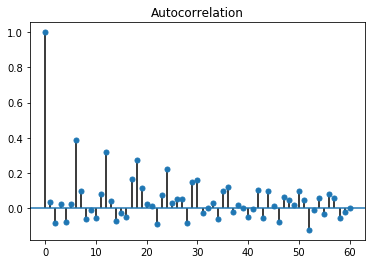

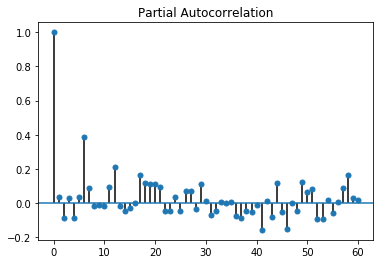

In [194]:
plt.figure(figsize=(10,10))
pm.plot_acf(train, lags=60)
pm.plot_pacf(train, lags=60)

Periodic correlation of data points is still detectible in the store 1 data, however it is not as strongly manifested as with overall data for all the stores. This could be due to mutiple factors, including  of the 

### Test Store 1 data for stationarity and manually find differencing hyperparameter, d  :

Several techniques were applied to determine whether time serie is stationary. This time series was determined to be non-stationary and differencing degree d= 1 will be applied in further analysis with ARIMA.

In [195]:
from statsmodels.tsa.stattools import adfuller

a1=adfuller(train['visitors'])
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(a1)

Test Statistic   -2.790254
p-value           0.059679
dtype: float64

In [196]:
for d in range(1, len(train['visitors'])):
    
    if interpret_dftest(adfuller(train['visitors'].diff(d).dropna()))['p-value']<0.05:
        print(f'Differencing by d={d} yields a stationary time series')
        break

Differencing by d=1 yields a stationary time series


In [197]:
from pmdarima.arima.stationarity import ADFTest
# pmdarima.arima

In [198]:
adf_test=ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(train)
p_val
should_diff

False

In [199]:
# from pmdarima.arima.utils import ndiffs
# n_adf = ndiffs(train, test='adf')
# n_adf

In [200]:
## Try to figure out the frequency of the data
np.diff(store1.index.values).min()
freq = 1e9 / np.diff(store1.index.values).min().astype(int)
freq

1.1574074074074073e-05

In [201]:
# d_range = pd.date_range('2016-01-13', '2017-04-22', freq='W')
# #d_range._set_freq(None)
# d_range.inferred_freq
# freq=store1.index.inferred_freq
# print (freq)

In [202]:
train.shape

(294, 1)

In [203]:
test.shape

(97, 1)

In [204]:
 from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train,  freq=7, model= 'multiplicative') # 'multiplicative'


#plot_mpl(fig)

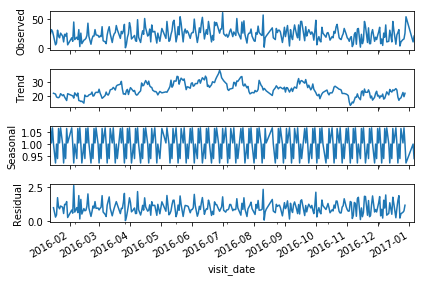

<Figure size 1440x720 with 0 Axes>

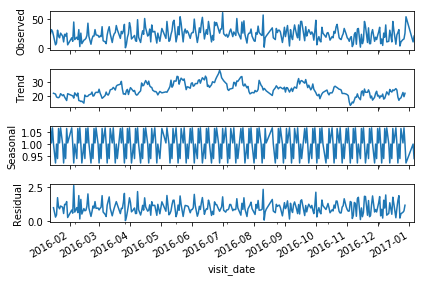

In [205]:
plt.figure(figsize=(20,10))
result.plot()
# plt.plot(result)

In [206]:
#!pip install pmdarima

In [207]:
#!pip install pyramid


### Estimating Seasonal differencing parameter,  D:

In [208]:

from pmdarima.arima.utils import nsdiffs


# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(train,
            m=42,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0
D

0

In [209]:
import pmdarima as pm

m1 = auto_arima(train, error_action='ignore', d=0, D=1, seasonal=True, suppress_warnings=True, m=7)
m12 = auto_arima(train, error_action='ignore', d=0, D=1,  seasonal=True, suppress_warnings=True, m=38)
#m_auto= auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)

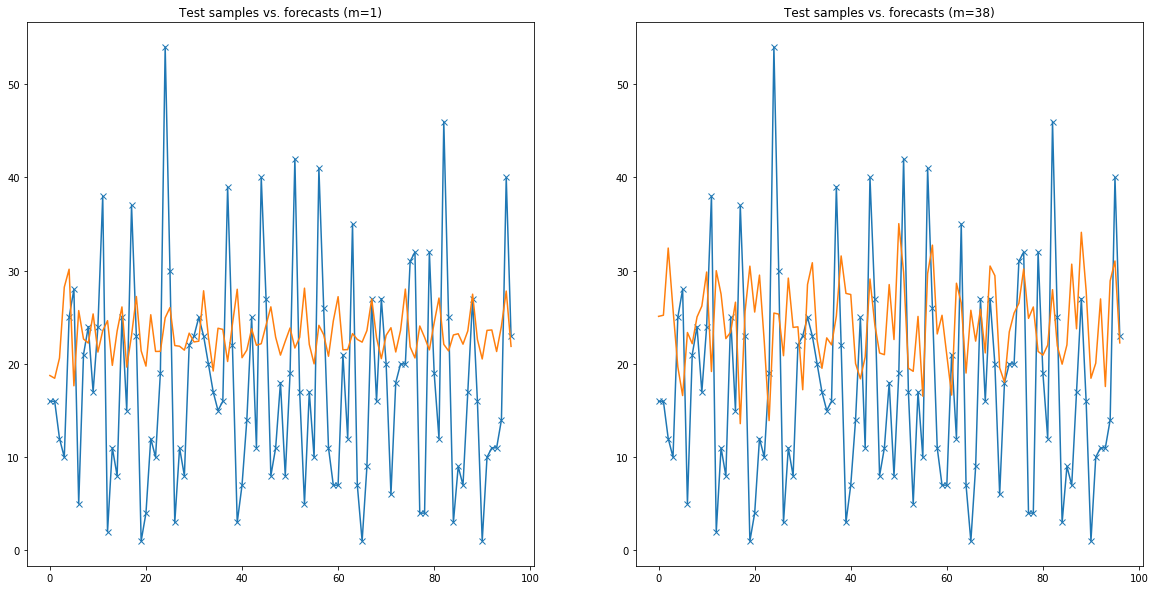

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
x = np.arange(test.shape[0])

# Plot m=1
axes[0].plot(x, test, marker='x')
axes[0].plot(x, m1.predict(n_periods=test.shape[0]))
axes[0].set_title('Test samples vs. forecasts (m=1)')

# Plot m=12
axes[1].plot(x, test, marker='x')
axes[1].plot(x, m12.predict(n_periods=test.shape[0]))
axes[1].set_title('Test samples vs. forecasts (m=38)')

# axes[2].plot(x, test, marker='x')
# axes[2].plot(x, m_auto.predict(n_periods=test.shape[0]))
# axes[2].set_title('Test samples vs. forecasts (m=auto)')

plt.show()

Through trial and error an optimal value for m was determined to be m=42 from visual inspection of the resulting fits. 

## Fitting Auto_arima: 

The parameters d and D were found manually above. The rest of the ARIMA hyperparameters are found below using the auto_arima pipeline from pmdarima package. 

In [211]:
step_model = auto_arima(train, start_p=0, start_q=0,
                           max_p=3, max_q=7, m=42,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 42); AIC=2032.870, BIC=2043.458, Fit time=1.750 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 42); AIC=2096.578, BIC=2103.637, Fit time=0.125 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 42); AIC=2056.747, BIC=2070.864, Fit time=3.312 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 42); AIC=2032.741, BIC=2046.859, Fit time=2.439 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 1, 42); AIC=2031.819, BIC=2049.466, Fit time=9.780 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 0, 42); AIC=2056.558, BIC=2070.676, Fit time=2.565 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 2, 42); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 0, 42); AIC=2095.893, BIC=2106.482, Fit time=0.920 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 1, 2, 42); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 

In [212]:
print('AIC:', step_model.aic())
print('BIC:', step_model.bic())

AIC: 1998.8080784535825
BIC: 2041.1612275037196


In [213]:
step_model.get_params

<bound method BaseEstimator.get_params of ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 0, 6),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 42), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)>

In [214]:
step_model.fit(train)
forecast1 = step_model.predict(n_periods=test.shape[0])


In [215]:
print('RMSE : ', sqrt(mean_squared_error(test, forecast1) ))
print( 'R^2:', r2_score(test['visitors'], forecast1))

RMSE :  14.140849530522434
R^2: -0.5930948408569994


#### RMSE metric found through ARIMA analysis was much higher than the baseline score and visual analysis of the fit did not accurately reflect the pattern of true data, for Store 1 as an example (see plot below). 

In [216]:
print(forecast1)

[23.55731338 17.51194341 29.88903864 41.31248093 16.04923384 20.40424049
 10.88879519 21.69182854 20.86883851 41.32758315 24.44871478 12.78409841
 20.16836777 24.49067825 35.54203296 31.91068982 23.62024648 12.27915195
 22.61795605 16.83424116 31.22104743 33.45916058 26.94692917 14.17416153
 19.66377553 19.80808931 28.58148549 27.50997138 25.28151534 21.04615987
 21.11445625 26.0537711  24.53379467 28.7464955  18.52363263 13.11094282
 27.03656775 25.41498914 26.32066917 34.89190218 21.04272878 15.43333099
 24.91123228 20.48928452 28.70364454 33.25832746 16.32045182 20.5742223
 16.9590961  22.02872625 19.63557155 36.0757919  23.39217612 14.12717452
 24.38754555 25.44771342 33.74165509 27.94779144 22.33489135 13.84825338
 25.88683367 17.8083474  29.3845435  30.23701925 25.75469676 15.67569808
 22.32652598 20.63593853 26.86715952 24.80322412 24.25695439 22.39876614
 23.32644918 26.70985138 22.97941364 26.44172252 17.66578125 14.30140139
 28.88543655 25.91397733 24.92578192 32.91789082 20.

Text(0.5, 1.0, 'Mean Visitors Over Time Store 1 Prediction vs. Reality')

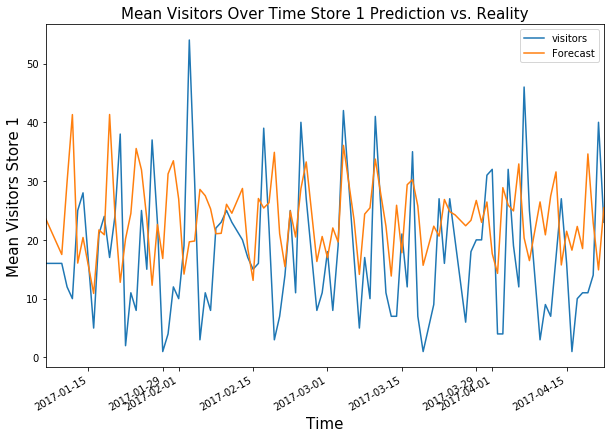

In [217]:
forecast1 = pd.DataFrame(forecast1,index = test.index,columns=['Forecast'])
pd.concat([test,forecast1],axis=1).plot(figsize=(10,7))
plt.ylabel('Mean Visitors Store 1', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Mean Visitors Over Time Store 1 Prediction vs. Reality', fontsize=15)

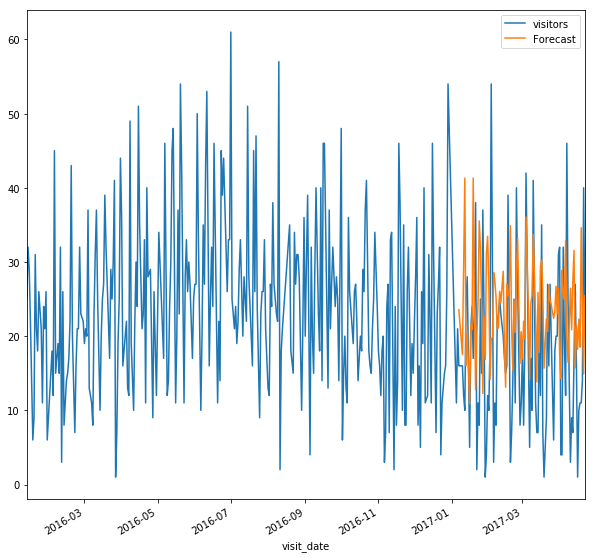

In [218]:
pd.concat([store1,forecast1],axis=1).plot(figsize=(10,10))

In [219]:

# mod1 = pm.auto_arima(store1, error_action='ignore', seasonal=True, m=1)
# mod12 = pm.auto_arima(store1, error_action='ignore', seasonal=True, m=12)

## Modeling store 1 data with Prophet
Next, Prophet (developed and provided by Facebook) package was used, which deals with seasonality and missing data among other aspects of time series data in a more automated statistical manner. This model resulted in a much better visual fit of time series yearly, weekly and daily patterns, however RMSE metric was still higher than the baseline score. 


In [220]:
#!pip install pystan

In [221]:
#!pip install fbprophet

In [222]:
# !conda install gcc
# !conda install -c conda-forge fbprophet


In [223]:
# import pystan, check if pystan works by running this code
# model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
# model = pystan.StanModel(model_code=model_code)  # this will take a minute
# y = model.sampling(n_jobs=1).extract()['y']
# y.mean()  # should be close to 0

In [224]:
# !pip freeze

In [225]:
from fbprophet import Prophet

In [226]:
#pm1=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True)
pm1=Prophet(interval_width=0.85, yearly_seasonality=True, weekly_seasonality=True) #mcmc_samples=2,

In [227]:
trainp, testp = store1[:294], store1[294:]
# trainp=train
# testp=test
trainp.head()

,visitors
visit_date,
2016-01-13,25
2016-01-14,32
2016-01-15,29
2016-01-16,22
2016-01-18,6


#### Train and Test data is converted into special format required by Prophet. 

In [228]:
trainp['ds'] = trainp.index
trainp['y'] = trainp.visitors
testp['ds'] = testp.index
testp['y'] = testp.visitors

# trainp.drop(['visitors'],axis = 1, inplace = True)
# testp.drop(['visitors'],axis = 1, inplace = True)

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [229]:
trainp.head()

,visitors,ds,y
visit_date,,,
2016-01-13,25,2016-01-13,25
2016-01-14,32,2016-01-14,32
2016-01-15,29,2016-01-15,29
2016-01-16,22,2016-01-16,22
2016-01-18,6,2016-01-18,6


In [230]:
trainp.drop(columns='visitors', inplace=True)
testp.drop(columns='visitors', inplace=True)

/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



#### Fitting the Prophet : 

In [231]:
pm1.fit(trainp)
Ppreds=pm1.make_future_dataframe (periods=97)
forecast = pm1.predict(Ppreds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning:

Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/dsi/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [232]:
Ppreds.shape

(391, 1)

In [233]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-13,23.994052,11.262006,37.420350,23.994052,23.994052,-0.152660,-0.152660,-0.152660,3.751373,3.751373,3.751373,-3.904033,-3.904033,-3.904033,0.0,0.0,0.0,23.841392
1,2016-01-14,23.981486,7.184847,32.961651,23.981486,23.981486,-4.102399,-4.102399,-4.102399,0.247156,0.247156,0.247156,-4.349555,-4.349555,-4.349555,0.0,0.0,0.0,19.879087
2,2016-01-15,23.968919,20.005489,45.236610,23.968919,23.968919,8.358600,8.358600,8.358600,13.147068,13.147068,13.147068,-4.788468,-4.788468,-4.788468,0.0,0.0,0.0,32.327519
3,2016-01-16,23.956353,13.756740,38.094672,23.956353,23.956353,1.462334,1.462334,1.462334,6.678372,6.678372,6.678372,-5.216038,-5.216038,-5.216038,0.0,0.0,0.0,25.418687
4,2016-01-18,23.931220,-0.394116,23.251715,23.931220,23.931220,-12.684887,-12.684887,-12.684887,-6.665251,-6.665251,-6.665251,-6.019636,-6.019636,-6.019636,0.0,0.0,0.0,11.246333
5,2016-01-19,23.918654,3.721315,28.540320,23.918654,23.918654,-8.059248,-8.059248,-8.059248,-1.671378,-1.671378,-1.671378,-6.387871,-6.387871,-6.387871,0.0,0.0,0.0,15.859405
6,2016-01-20,23.906087,7.817376,33.922816,23.906087,23.906087,-2.977941,-2.977941,-2.977941,3.751373,3.751373,3.751373,-6.729314,-6.729314,-6.729314,0.0,0.0,0.0,20.928146
7,2016-01-21,23.893521,4.156388,28.942982,23.893521,23.893521,-6.794162,-6.794162,-6.794162,0.247156,0.247156,0.247156,-7.041319,-7.041319,-7.041319,0.0,0.0,0.0,17.099359
8,2016-01-22,23.880955,16.662801,42.560978,23.880955,23.880955,5.825251,5.825251,5.825251,13.147068,13.147068,13.147068,-7.321817,-7.321817,-7.321817,0.0,0.0,0.0,29.706206
9,2016-01-23,23.868388,10.285046,35.938663,23.868388,23.868388,-0.890965,-0.890965,-0.890965,6.678372,6.678372,6.678372,-7.569337,-7.569337,-7.569337,0.0,0.0,0.0,22.977423


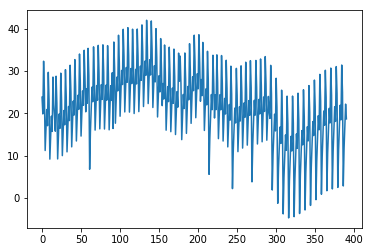

In [234]:
plt.plot(forecast['yhat'])

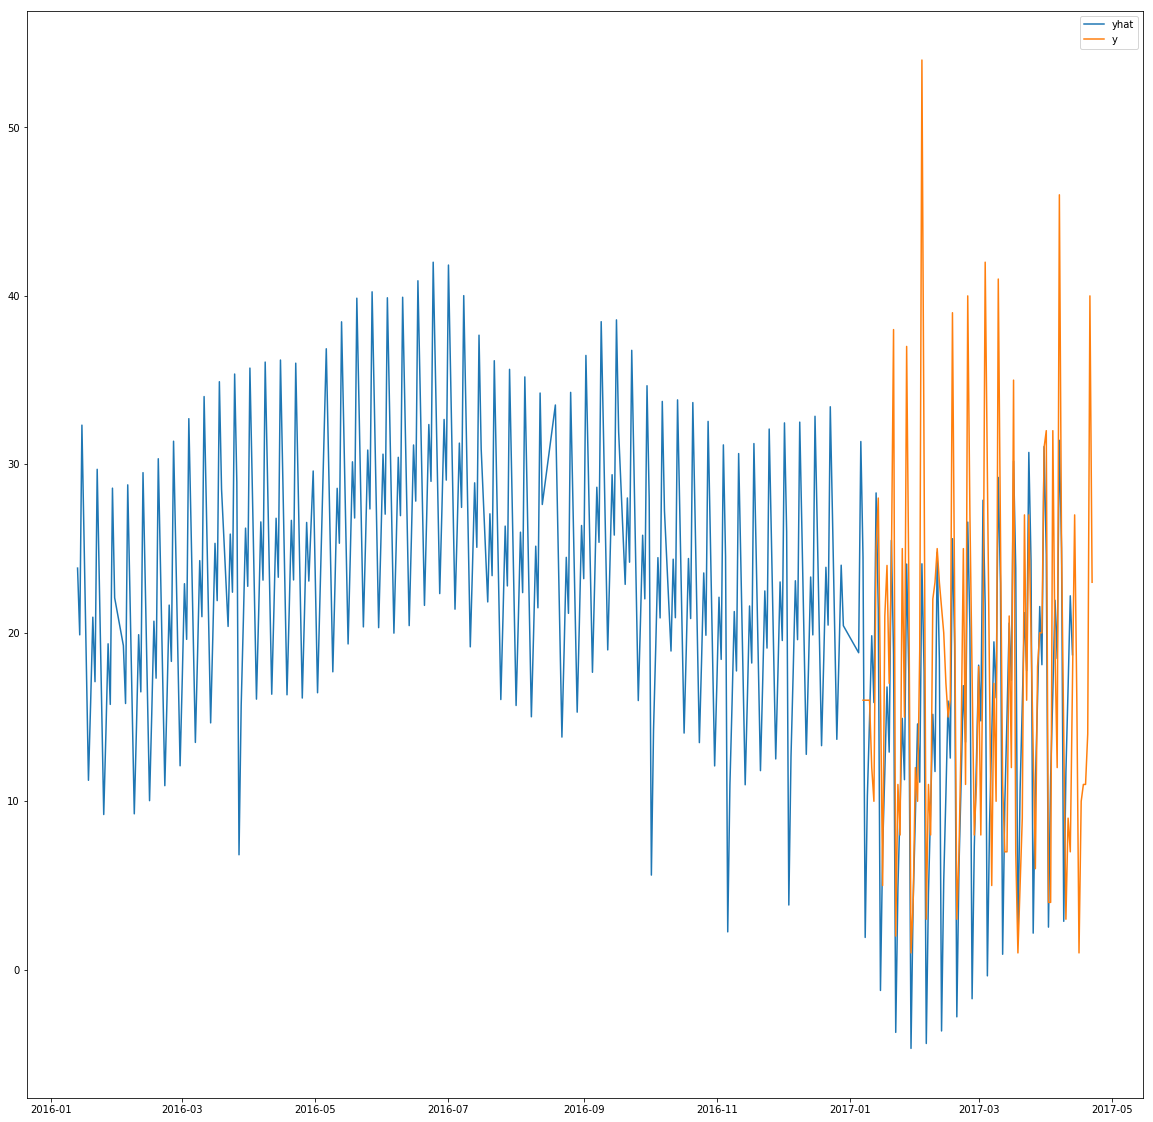

In [235]:
plt.figure(figsize=(20,20))
#plt.plot(trainp['ds'], trainp['y'])
plt.plot(forecast['ds'], forecast['yhat'])
plt.plot(testp['ds'], testp['y'])
plt.legend()

In [236]:
#forecast1 = pd.DataFrame(forecast1,index = test.index,columns=['Forecast'])


In [237]:
print('RMSE : ', sqrt(mean_squared_error(testp['y'], forecast['yhat'][294:]) ))
print( 'R^2:', r2_score(testp['y'], forecast['yhat'][294:]))

RMSE :  14.974236100534434
R^2: -0.7864052314547474


####  The RMSE metric is still much higher than the baseline score and the negative R^2 indicate a poor fit of the model produced using Prophet analysis. While the visual fit (seen below) was improved significantly. The visual fit roughly capturing the weekly pattern of the time seriew of the Store 1 example, however it is not capturing precise details, e.g. spikes/falls, of the real data. 

In [238]:
print(testp['y'].shape)
print(forecast['yhat'][294:].shape)

(97,)
(97,)


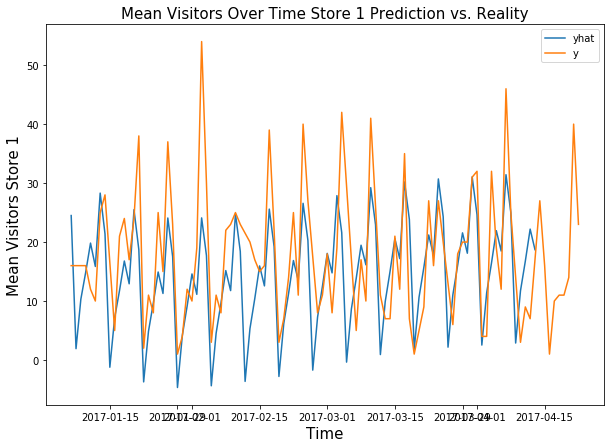

In [239]:
plt.figure(figsize=(10,7))
#plt.plot(trainp['ds'], trainp['y'])
plt.plot(forecast['ds'][294:], forecast['yhat'][294:])# testp['ds']
plt.plot(testp['ds'], testp['y'])
plt.ylabel('Mean Visitors Store 1', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Mean Visitors Over Time Store 1 Prediction vs. Reality', fontsize=15)
plt.legend()

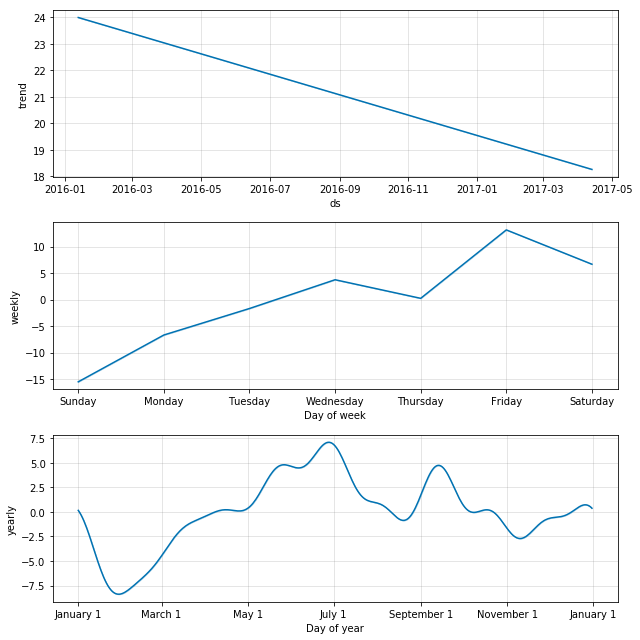

In [240]:
fig1=pm1.plot_components(forecast)

## Model Time Data as a Regression Problem :

### Analysis Set up: 
Finally, the problem was reformulated for a multiple feature regression analysis. Here advantage was taken of several relational data based in the dataset. The customer visit database was merged with databases containing information on geo-spatial latitude and longitude, cuisine genre, type of restaurant, which were used as features in the regression analysis. In addition, statistical summaries of week-day specific visitors minimum, maximum, mean, median for each specific restaurant, which values were also used as features in the regression analysis. Visit date parameter (originally in year-month-day format) was decomposed into four different features of year, month, day of the year and weekday and all four parameters were used as separate features in the regression analysis. This merged database with engineered features and containing all of the restaurants in the system was used in the regression analysis using Random Forest model. Resulting forecast resulted in visitor predictions for each restaurant with a record-low RMSE value, drastically lower than the baseline score.

In [241]:
# air_dist=pd.read_csv('./rrv-weather-data/air_station_distances.csv')
# air_info_station = pd.read_csv('./rrv-weather-data/air_store_info_with_nearest_active_station.csv')
# hpg_dist=pd.read_csv('./rrv-weather-data/hpg_station_distances.csv')
# hpg_info_station=pd.read_csv('./rrv-weather-data/hpg_store_info_with_nearest_active_station.csv')
# feature_man=pd.read_csv('./rrv-weather-data/feature_manifest.csv')
# stations=pd.read_csv('./rrv-weather-data/weather_stations.csv')
# ac_stations=pd.read_csv('./rrv-weather-data/nearby_active_stations.csv')


### Feature Engineered Data Preprocessing

1. See EDA for Feature Engineering

In [4]:
data=pd.read_csv('../data/dataAll.csv')

/anaconda3/envs/dsi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
data.drop(columns=['Unnamed: 0','day_of_week','reserve_datetime','reserve_visitors'], inplace=True)
data.head(2)

,air_store_id,visit_date,visitors,year,month,day,weekday,air_genre_name,air_area_name,latitude,longitude,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13,Wednesday,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0,7,23.843750,25.0,57
1,air_25e9888d30b386df,2016-01-13,21,2016,1,13,Wednesday,Izakaya,Tōkyō-to Shinagawa-ku Higashigotanda,35.626568,139.725858,0,1,6.921569,4.0,28


Categorical data features are numerically encoded with Label Encoder.

In [6]:
lbl = preprocessing.LabelEncoder()
data['air_genre_name'] = lbl.fit_transform(data['air_genre_name'])
data['air_area_name'] = lbl.fit_transform(data['air_area_name'])
data['weekday'] = lbl.fit_transform(data['weekday'])

In [7]:
data.head()

,air_store_id,visit_date,visitors,year,month,day,weekday,air_genre_name,air_area_name,latitude,longitude,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13,6,4,62,35.658068,139.751599,0,7,23.843750,25.0,57
1,air_25e9888d30b386df,2016-01-13,21,2016,1,13,6,7,75,35.626568,139.725858,0,1,6.921569,4.0,28
2,air_fd6aac1043520e83,2016-01-13,40,2016,1,13,6,7,62,35.658068,139.751599,0,9,35.272727,37.5,60
3,air_64d4491ad8cdb1c6,2016-01-13,5,2016,1,13,6,4,62,35.658068,139.751599,0,4,15.746269,15.0,55
4,air_ee3a01f0c71a769f,2016-01-13,18,2016,1,13,6,2,37,34.710895,137.725940,0,4,19.278689,18.0,79


##### Stores can be looked at separately by finding IDs of the unique stores in the whole database: 

In [8]:
unique_id= data['air_store_id'].unique()

In [11]:
store01 = data[data['air_store_id']==rest_id[0]]
store01.drop(columns='air_store_id', inplace=True)
store01.set_index('visit_date', inplace=True)
store01.index = pd.to_datetime(store01.index )

/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [13]:
#plt.plot(store1['visitors'])

### Modeling the whole dataAll database:

Complete database with all stores will be used in data analysis with all of the engineered features (captured in Exploratory Analysis notebook) included. Random Forest Regressor model will be used to model the data and learn feature importance. 

In [15]:
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [16]:
features = [c for c in data if c not in ['air_store_id','visit_date','visitors']]

In [17]:
X=data[features]
y=data['visitors']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()

,year,month,day,weekday,air_genre_name,air_area_name,latitude,longitude,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors
224241,2016,5,136,3,2,0,33.586994,130.394894,0,1,25.014925,15.0,102
56794,2016,8,214,1,1,86,35.726118,139.716605,0,1,3.785714,3.0,12
157840,2017,1,23,1,7,1,33.591358,130.414878,0,5,22.843750,21.0,47
3452,2016,1,27,6,6,45,35.672114,139.770825,0,2,7.704918,8.0,16
166999,2017,2,35,2,1,45,35.672114,139.770825,0,8,26.367647,25.0,49


In [19]:
len(X_train.columns)

13

In [37]:
# setting up the pipe
pipe= Pipeline([
    ('rf', RandomForestRegressor(random_state=42))
     #'gbr', GradientBoostingRegressor()
])

In [38]:
# setting up a stand-alone model for feature importance determination
forest=RandomForestRegressor(random_state=42)

In [22]:
# fit produced using a pipe
pipe.fit(X_train, np.log1p(y_train.values))

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [39]:
# fit produced using a stand alone model to enable feature importance determination
forest_fit = forest.fit(X_train, np.log1p(y_train.values))

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [24]:
# preds=pipe.predict(X_test)
# preds1 = np.expm1(preds)

In [25]:
predictions=pipe.predict(X)
predictions1=np.expm1(predictions)

In [26]:
pred_f=forest.predict(X)
pred_f=np.expm1(pred_f)

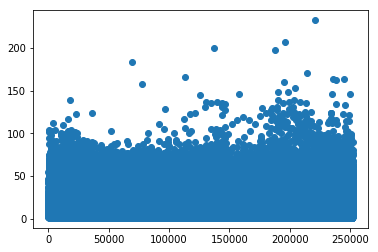

In [27]:
plt.scatter(y=predictions1, x=np.arange(predictions1.shape[0]))

In [28]:
# plt.scatter(y=preds1, x=np.arange(preds1.shape[0]))

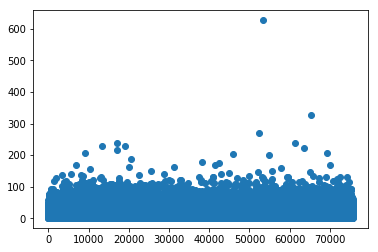

In [29]:
plt.scatter(y=y_test, x=np.arange(y_test.shape[0]))

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt


In [31]:
print('RMSE : ', sqrt(mean_squared_error(np.log1p(y), pipe.predict(X)) ))
print( 'R^2:', r2_score(np.log1p(y), pipe.predict(X)))

RMSE :  0.35568235793006114
R^2: 0.8060898692292854


In [32]:
print('RMSE : ', sqrt(mean_squared_error(np.log1p(y), forest.predict(X)) ))
print( 'R^2:', r2_score(np.log1p(y), forest.predict(X)))

RMSE :  0.35568235793006114
R^2: 0.8060898692292854


In [36]:
print('RMSE : ', sqrt(mean_squared_error(np.log1p(y_test), forest.predict(X_test)) ))
print( 'R^2:', r2_score(np.log1p(y_test), forest.predict(X_test)))

RMSE :  0.5469418985585939
R^2: 0.5415522860908795


In [34]:
data['preds']=predictions1

Regression analysis using engineered features and regression analysis with Random Forest model resulted in RMSE score of 0.36 on the entire dataset and 0.55 on the test dataset and corresponding R^2 scores of 0.8 and 0.54. These scores are much lower than the baseline RMSE of 11.1 and R^2 of 0.56. It is evident that test score was lower than the train score and the score of the entire dataset prediction. While the model is overfitting the train set relative to test set and additional work is needed to level out the scores to make more accurate prediction. However the fact that RMSE score produced by this model is so much lower than the baseline, this analysis provides proof of principle and strong evidence that regression analysis with engineered features is highly suitable for analysis of the time series data and forecasting visitors, given the data. 

### Look at the data for for the first Store :

Plot of the visitors forcasting vs. true visitor data below demonstrates visual accuracy of the predictions extracted from Random Forest regression analysis.

In [40]:
store01 = data[data['air_store_id']==rest_id[0]]
store01.head()
#store01.drop(columns='air_store_id', inplace=True)

,air_store_id,visit_date,visitors,year,month,day,weekday,air_genre_name,air_area_name,latitude,longitude,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,preds
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13,6,4,62,35.658068,139.751599,0,7,23.843750,25.0,57,19.356085
263,air_ba937bf13d40fb24,2016-01-14,32,2016,1,14,4,4,62,35.658068,139.751599,0,2,20.292308,21.0,54,31.745921
537,air_ba937bf13d40fb24,2016-01-15,29,2016,1,15,0,4,62,35.658068,139.751599,0,4,34.738462,35.0,61,28.452820
827,air_ba937bf13d40fb24,2016-01-16,22,2016,1,16,2,4,62,35.658068,139.751599,0,6,27.651515,27.0,53,20.006466
1109,air_ba937bf13d40fb24,2016-01-18,6,2016,1,18,1,4,62,35.658068,139.751599,0,2,13.754386,12.0,34,14.217674


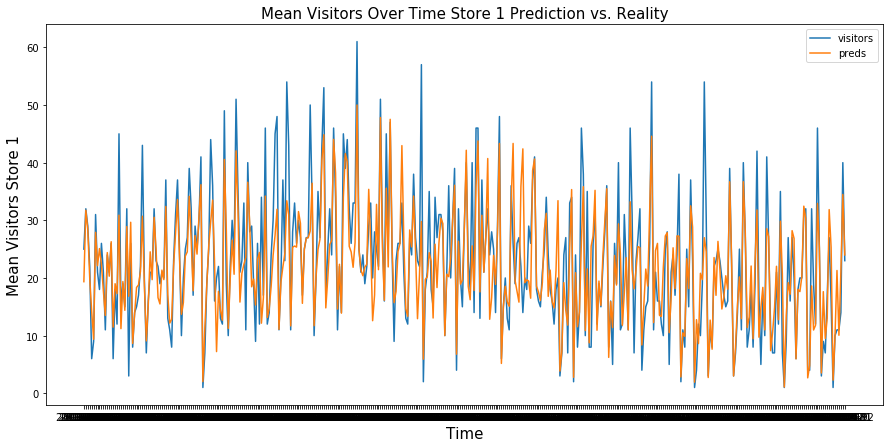

In [41]:
plt.figure(figsize=(15,7))
#plt.plot(trainp['ds'], trainp['y'])
plt.plot(store01['visit_date'], store01['visitors'])
plt.plot(store01['visit_date'], store01['preds'])
plt.ylabel('Mean Visitors Store 1', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Mean Visitors Over Time Store 1 Prediction vs. Reality', fontsize=15)
plt.legend()

In [ ]:
plt.figure(figsize=(10,7))
#plt.plot(trainp['ds'], trainp['y'])
plt.plot(store01['visit_date'][294:], store01['preds'][294:])
plt.plot(store01['visit_date'][294:], store01['visitors'][294:])
plt.ylabel('Mean Visitors Store 1', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Mean Visitors Over Time Store 1 Prediction vs. Reality', fontsize=15)
plt.legend()

In [42]:
X.columns

Index(['year', 'month', 'day', 'weekday', 'air_genre_name', 'air_area_name',
       'latitude', 'longitude', 'holiday_flg', 'min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors'],
      dtype='object')

### Feature Importance from Random Forest model: 

In [43]:
importances = list(zip(forest.feature_importances_, X.columns))
#print(importances.sort(reverse=True))
importances

[(0.008833930588983688, 'year'),
 (0.01947776910736367, 'month'),
 (0.17570063603053782, 'day'),
 (0.016504035012570275, 'weekday'),
 (0.018823432760925, 'air_genre_name'),
 (0.02265836933179478, 'air_area_name'),
 (0.020878460203049468, 'latitude'),
 (0.0199709804224314, 'longitude'),
 (0.0062386445560727805, 'holiday_flg'),
 (0.015089377745004032, 'min_visitors'),
 (0.16220480899076234, 'mean_visitors'),
 (0.47991370176534376, 'median_visitors'),
 (0.033705853485160954, 'max_visitors')]

In [44]:
imp_df=pd.DataFrame(importances).sort_values(by=0, ascending=False)
imp_df

,0,1
11,0.479914,median_visitors
2,0.175701,day
10,0.162205,mean_visitors
12,0.033706,max_visitors
5,0.022658,air_area_name
6,0.020878,latitude
7,0.019971,longitude
1,0.019478,month
4,0.018823,air_genre_name
3,0.016504,weekday


Text(0.5, 1.0, 'Feature Importance')

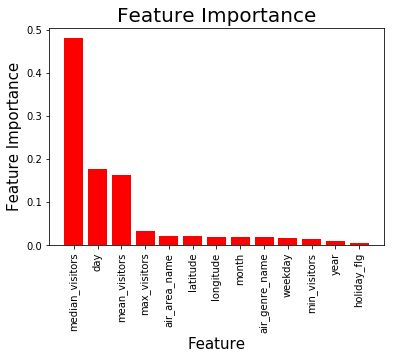

In [45]:
plt.figure()
plt.title("Feature importances")
plt.bar (imp_df[1], imp_df[0], color="r",  align="center") #
plt.tick_params(axis='x', labelrotation=90)
plt.ylabel('Feature Importance', fontsize=15)
plt.xlabel('Feature', fontsize=15)
plt.title('Feature Importance', fontsize=20)

### Feature importance: 
Above graph demonstrates importance of individual features extracted from the Random Forest model results. This shows that some of the features are more important than others in predicting future visitors. It is possible that taking some of these features from the analysis would reduce the degree of error due to high variance obtained in the analysis above. In addition, it is possible that incorporating new engineered features would also have beneficial effect. For example, in future analysis, new features could be explored, using local weather data and geo-spatial coordinates analysis. First advantage can be taken from geo-spatial data, for example determining spatial proximity of each restaurant to the busiest areas and to competing stores. Second, data about the weather in different areas of the country could be used and additional features could be engineered from this data to be used in the proposed regression model. 

## Conclusions: 
Prediction of daily visitors at different restaurants in Japan depends on many different parameters, including date, location, cuisine genre, restaurant type. This type of data is easily accessible through combination of data mining and datasets collected through AirRegi/Restaurant board website. Accurate forecasting of future restaurant visitors was achieved via data science modeling process and may be used to significantly relieve the pressure of planning daily operations in tough restaurant business

### Tune Parameters for the Pipe: 

Tuning parameters in the pipe model did not result in optimal fit and is not included in the report above. However it is included below as supplementary material and material for future work.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# params = { 
#             'rf__n_estimators':[90,150,200],
#             'rf__max_depth' : [15,25,35]
#                   }
# grid = GridSearchCV(pipe, params, cv = 3)
 
# # Fit and tune model
# # grid.fit(X_train, np.log1p(y_train.values))

In [ ]:
# grid.get_params

In [ ]:
# grid.fit(X_train, np.log1p(y_train.values))

In [ ]:
# grid.best_params_

In [ ]:
# preds2=grid.predict(X_test)
# preds3=np.expm1(preds2)

In [ ]:
# print('RMSE : ', sqrt(mean_squared_error(np.log1p(y), grid.predict(X)) ))

In [ ]:
# print( 'R^2:', r2_score(np.log1p(y), grid.predict(X)))

### RNN Fitting

Data modeling with RNN was carried out, however did not produce a satisfying fit. Analysis is included below as supplementary material, however is not included in technical report, as further improvement of this analysis will be performed in the future.

In [ ]:
data=pd.read_csv('../data/dataAll.csv')

In [ ]:
data.drop(columns=['Unnamed: 0','day_of_week','reserve_datetime','reserve_visitors'], inplace=True)
lbl = preprocessing.LabelEncoder()
data['air_genre_name'] = lbl.fit_transform(data['air_genre_name'])
data['air_area_name'] = lbl.fit_transform(data['air_area_name'])
data['weekday'] = lbl.fit_transform(data['weekday'])

In [ ]:
rnn_data=data

In [ ]:
rnn_data.head(2)

In [ ]:
rnn_data['visit_date']=pd.to_datetime(rnn_data['visit_date'])
rnn_data.set_index('visit_date', inplace=True)


In [ ]:
rnn_data.head(2)

In [ ]:
features = [c for c in data if c not in ['air_store_id','visit_date','visitors']]

In [ ]:
## fitting RNN for one store:

store01 = rnn_data[rnn_data['air_store_id']==rest_id[0]]
store01.head()

In [ ]:
X1=store01[features]
y1=store01['visitors'].values

In [ ]:
X1.head()

In [ ]:
X1.drop(columns=['air_genre_name', 'air_area_name', 'latitude', 'longitude' ], inplace=True)

In [ ]:
X1.dtypes

In [ ]:
#X1['latitude']=X1['latitude'].astype(int)
#X1['longitude']=X1['longitude'].astype(int)
X1['mean_visitors']=X1['mean_visitors'].astype(int)
X1['median_visitors']=X1['median_visitors'].astype(int)

In [ ]:
X1.head()

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, shuffle=False)
X_train1.head()

In [ ]:
X_train1.dtypes

In [ ]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train1)
X_test_sc = ss.transform(X_test1)

In [ ]:
X_train_sc

In [ ]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train1, length=9, batch_size=64)
batch_x, batch_y = train_sequences[0]


In [ ]:
train_sequences

In [ ]:
batch_x[0]

In [ ]:
batch_x.shape

In [ ]:
batch_y.shape

In [ ]:
batch_x[0]

In [ ]:
pd.DataFrame(X_train_sc, columns=X_train1.columns).head(3)

In [ ]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test1, length=9, batch_size=64)

### Modeling

In [ ]:
model = Sequential()
model.add(GRU(12, input_shape=(9, 9), return_sequences=True)) # 3 is # loops and 8 is num of features
model.add(GRU(12))

model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='linear'))

In [ ]:
from keras import optimizers


In [ ]:
#model.compile(optimizer=Adam(lr=.0005), loss='mean_squared_error', metrics=['acc'])
model.compile(optimizer=optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=1e-6), loss='mean_squared_error', metrics=['mae'])
history = model.fit_generator(train_sequences, validation_data=test_sequences, epochs=25, verbose=0)

In [ ]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();

In [ ]:
# plt.plot(history.history['mae'], label='Train accuracy')
# plt.plot(history.history['val_mae'], label='Test accuracy')
# plt.legend();

In [ ]:
preds=model.predict_generator(test_sequences)

In [ ]:
model.predict_generator(test_sequences)[:,0].min()

In [ ]:
preds[:5]

In [ ]:
pd.DataFrame(preds).plot()

In [ ]:
pd.DataFrame(y_test1).plot()

In [ ]:
#X_test1.index

In [ ]:
plt.figure(figsize=(10,10))
#plt.plot(trainp['ds'], trainp['y'])
plt.plot( preds)
plt.plot( y_test1[7:])
# plt.scatter(x=forecast['ds'], y=forecast['yhat_upper'])
# plt.scatter(x=forecast['ds'], y=forecast['yhat_lower'])
# plt.scatter(x=forecast['ds'], y=forecast['trend'])
plt.legend()